#  Generating a pipeline for microscopy data

In [66]:
# Standard dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Custom written modules
import mwc_induction_utils as mwc

# Image processing functions
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation
import scipy.ndimage

# For parallelization of arduous median filtering operations
import joblib as jlb

# Set the plotting environment.
%matplotlib notebook
sns.set_context('notebook')
sns.set_style('dark')
mwc.set_plotting_style()

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Thus far, all data has been collected on a MiltenyiBiotec MACSQuant flow cytometer. While this provides an incredibly high throughput method for making single-cell measurments, much information is lost as each cell only gives two real values -- scattering and integrated intensity. As all previous work in the lab has been performed using quantitative microscopy, we have taken a few measurements using a high-sensitivity laser illumination epifluorescence microscope. To make processing and analysis of microscopy data simpler, we need to develop a pipeline to extract fold change measurements from images.

###  Generating a flat-field image

Our microscopy set up is a Nikon TI-Eclipse inverted epifluoresence microscope outfitted with YFP (520nm) and TRITC (650nm **confirm this**) laser lines. The emission filters are designed for on-peak emission of YFP and have a remarkably flat dichroic mirror. The TRITC cube is designed for Hg lamp excitation, but works well for our laser system as well. Since we are not extracting quantitative information from the TRITC channel and are only using it for segmentation, this will not be an issue. 

However, we must correct for uneven illumination in the YFP channel since this happens to be the channel from which we would like to extract mean fluorescence values from. Our laser path results in an uneven illumination across the field of view during YFP excitation taking the shape of a two dimensional gaussian. This means that cells that happen to be closer to the edge of the field of view will be dimmer than those in the center. To correct for this, we correct each individual image such that it is flat in illumination across the entire sample. To perform this correction, we image a plastic fluorescence slide (Autofluorescent Plastic Slides, Chroma cat. no. 92001) in the YFP channel approximately 20 times and create an average intensity image. This gives an average image of the excitation illumination pattern. We then correct for uneven illumination by renormalizing each image as 

$$
\begin{align}
I_\mathrm{norm} = \frac{I - I_\mathrm{dark}}{I_\mathrm{field} - I_\mathrm{dark}}\mathrm{mean}(I_\mathrm{field} - I_\mathrm{dark})
\end{align}
$$

in which $I_\mathrm{norm}$ is the flat-field corrected image, $I_\mathrm{field}$ is teh average image of the illumination field and $I_\mathrm{dark}$ is an average image with no illumination and represents the camera shot noise. Prior to this correction, each image is median filtered with a 5x5 square structuring element to help correct for signal noise. We define the functions used for this correction below. 


In [134]:
def average_stack(im, median_filt=True, n_threads=1):
    """
    Computes an average image from a provided array of images.

    Parameters
    ----------
    im : list or arrays of 2d-arrays
        Stack of images to be filtered.
    median_filt : bool
        If True, each image will be median filtered before averaging.
        Median filtering is performed using a 5x5 square structural element.

    Returns
    -------
    im_avg : 2d-array
        averaged image with a type of int.
    """


    # Determine if the images should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(5)
        im_filt = [scipy.ndimage.median_filter(i, footprint=selem) for i in im]
        
    else:
        im = im_filt

    # Generate and empty image to store the averaged image.
    im_avg = np.zeros_like(im[0]).astype(int)
    for i in im:
        im_avg += i
    im_avg = im_avg / len(im)
    return im_avg

def _scipy_median_filt(im, selem):
    """Applies a median filter in a pickleable manner"""
    return scipy.ndimage.median_filter(im, footprint=selem)

def generate_flatfield(im, im_dark, im_field):
    """
    Corrects illumination of a given image using a dark image and an image of
    the flat illumination.

    Parameters
    ----------
    im : 2d-array
        Image to be flattened.
    im_dark : 2d-array
        Average image of camera shot noise (no illumination).
    im_field: 2d-array
        Average image of fluorescence illumination.

    Returns
    -------
    im_flat : 2d-array
        Image corrected for uneven fluorescence illumination. This is performed
        as

        im_flat = ((im - im_dark) / (im_field - im_dark)) *
                   mean(im_field - im_dark)

    Raises
    ------
    RuntimeError
        Thrown if bright image and dark image are approximately equal. This
        will result in a division by zero.
    """

    # Ensure that the same image is not being provided as the bright and dark.
    if np.isclose(im_field, im_dark).all():
        raise RuntimeError('im_bright and im_dark are approximately equal.')
        
    # Compute the mean difference between the bright and dark image.
    mean_diff = np.mean(im_field - im_dark)

    # Compute and return the flattened image.
    im_flat = ((im - im_dark) / (im_field - im_dark)) * mean_diff
    return im_flat


Let's try this functions out on some actual microscopy images.

In [135]:
# Define the data directory 
data_dir = '../../data/microscopy/20161018/'

# Load the dark and field images. 
dark_glob = glob.glob(data_dir + '*camera_noise*/*tif')
field_glob = glob.glob(data_dir + '*YFP_profile*/*tif')
dark_ims = skimage.io.ImageCollection(dark_glob, conserve_memory=False)
field_ims = skimage.io.ImageCollection(field_glob, conserve_memory=False)

We can begin by looking at a representative image of the field and dark images.

<IPython.core.display.Javascript object>


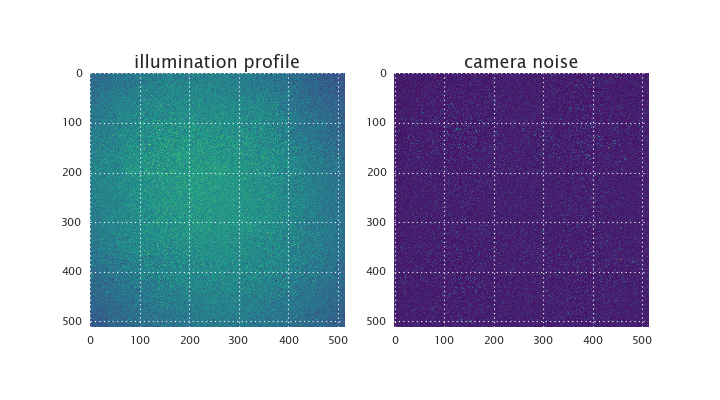

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(field_ims[0], cmap=plt.cm.viridis)
ax[0].set_title('illumination profile', fontsize=16)
ax[1].imshow(dark_ims[0], cmap=plt.cm.viridis)
ax[1].set_title('camera noise', fontsize=16)

We can see that the pixel values certainly do appear to be higher in the middle of the illumination profile while there is a bunch of shot noise in the camera image. We will now generage average images of each. 

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


<IPython.core.display.Javascript object>


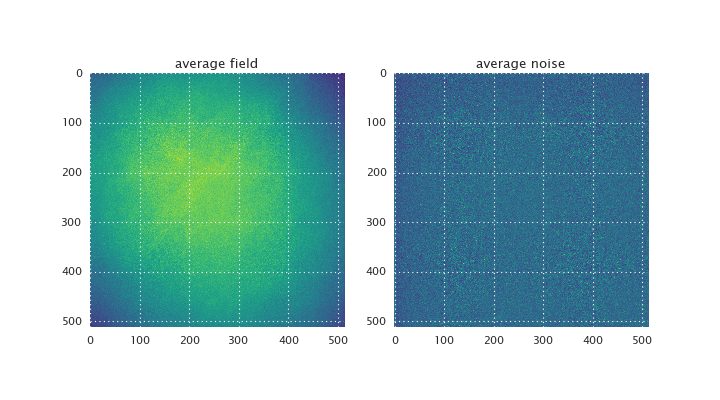

In [137]:
# Generate average images.
average_field = average_stack(field_ims)
average_dark = average_stack(dark_ims)

# Plot each average image. 
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(average_field, cmap=plt.cm.viridis)
ax[0].set_title('average field')
ax[1].imshow(average_dark, cmap=plt.cm.viridis)
ax[1].set_title('average noise')

Now that we have generated the average illumination profile and the average noise pattern, we can correct one of our images as an example. 

<IPython.core.display.Javascript object>


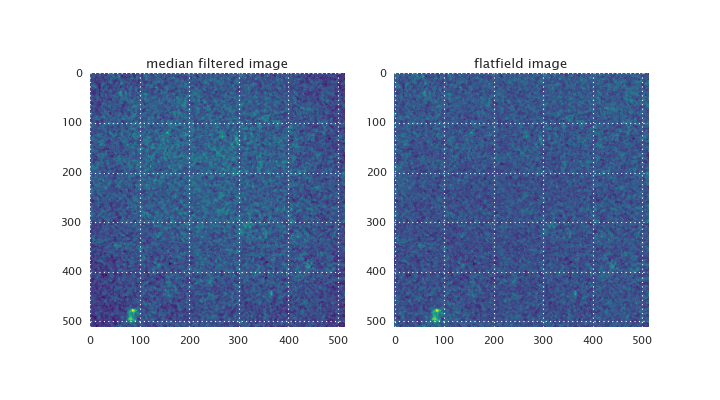

In [146]:
# Load an example image.
im = glob.glob(data_dir + '20161018_wt_O2_auto_0uMIPTG_2/*tif')
ex_im = skimage.io.imread(im[0])
yfp_im =  ex_im[:, :, 2]

# Correct for uneven illumination.
selem = skimage.morphology.square(5)
yfp_filt = scipy.ndimage.median_filter(yfp_im, footprint=selem)
yfp_flat = generate_flatfield(yfp_filt, average_dark, average_field)


# Show both.
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(yfp_filt, cmap=plt.cm.viridis)
ax[0].set_title('median filtered image')
ax[1].imshow(yfp_flat, cmap=plt.cm.viridis)
ax[1].set_title('flatfield image')

We can prove that this corrects the uneven illumination by taking a profile across each dimension of the image before and after filtering.

<IPython.core.display.Javascript object>


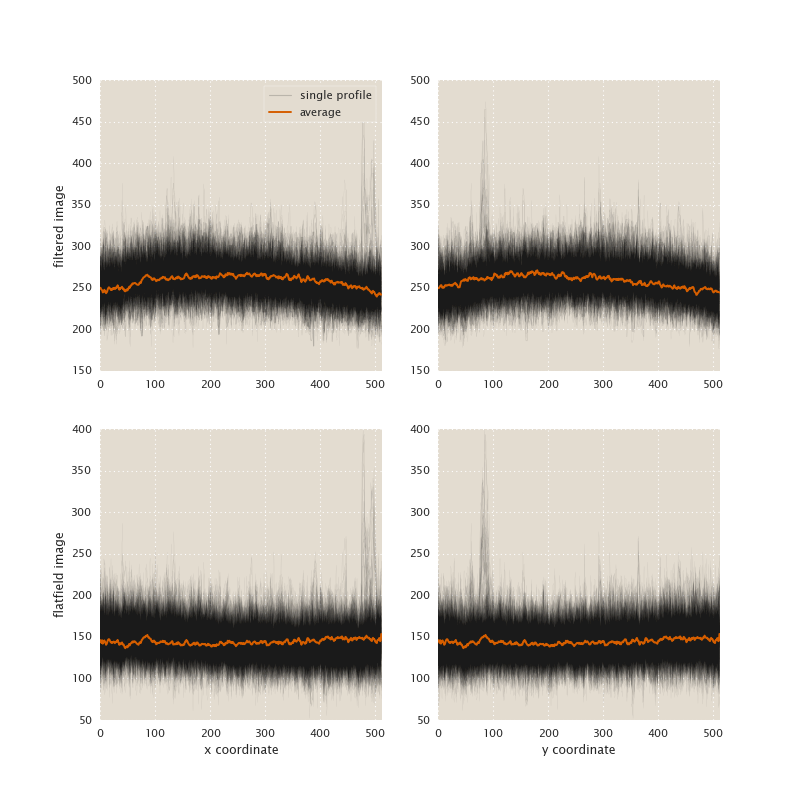

In [147]:
# Plot the profile and compute the average for the filtered and unfiltered case.
fig, ax = plt.subplots(2, 2, figsize=(10,10))
avg_prof_x = []
avg_prof_y = []
im_shape = np.shape(yfp_filt)
x_range = np.arange(0, im_shape[1], 1)
y_range = np.arange(0, im_shape[0], 1)

# Generate averages
filt_avg_y, flat_avg_y = [], []
filt_avg_x, flat_avg_x = [], []
for i in range(im_shape[0]):
    filt_avg_y.append(np.mean(yfp_filt[i, :]))
    flat_avg_y.append(np.mean(yfp_flat[i, :]))
    ax[0, 1].plot(y_range, yfp_filt[i, :], 'k-', linewidth=0.1, alpha=0.2)
    ax[1, 1].plot(y_range, yfp_flat[i, :], 'k-', linewidth=0.1, alpha=0.2)
for i in range(im_shape[1]):
    filt_avg_x.append(np.mean(yfp_filt[:, i]))
    flat_avg_x.append(np.mean(yfp_flat[:, i]))
    if i == 1:
        ax[0, 0].plot(x_range, yfp_filt[:, i], 'k-',
                      linewidth=1, alpha=0.2, label='single profile')
    else:
        ax[0, 0].plot(x_range, yfp_filt[:, i], 'k-', linewidth=0.1, alpha=0.2)
    ax[1, 0].plot(x_range, yfp_flat[:, i], 'k-', linewidth=0.1, alpha=0.2)
    
# Now plot the averages over each.
ax[0, 0].plot(x_range, filt_avg_x, 'r-', label='average')
ax[0, 0].legend(loc='upper right')
ax[0, 1].plot(y_range, filt_avg_y, 'r-')
ax[1, 0].plot(x_range, flat_avg_x, 'r-')
ax[1, 1].plot(x_range, flat_avg_x, 'r-')

# Label things so we know what is what
ax[0, 0].set_ylabel('filtered image')
ax[1, 0].set_ylabel('flatfield image')
ax[1, 0].set_xlabel('x coordinate')
ax[1, 1].set_xlabel('y coordinate')

axes = ax.ravel()
for a in axes:
    a.set_xlim([0, 512])